In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from typing import NamedTuple
from dataclasses import dataclass
from enum import IntEnum
from typing import Callable
import hybrid

# Birth death extinction probability

In [2]:
seed = None
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

initial_pop = 10
y0 = np.array([10e10,initial_pop])

# births and deaths: we have an irrelevant birth/death process for a large scale species (to test that our system is well isolated)
# and a birth death process for a small-valued species
N = np.array([[1, -1,0,0],[0,0,1,-1]])
rate_involvement_matrix = np.array([[1, 1,0,0],[0,0,1,1]])

birth_rate = 11
death_rate = 10

from numba import jit, float64
from numba.types import Array

@jit(Array(float64, 1, "C")(float64), nopython=True)
def birth_death_rate_constants(t):
    return np.array([1.1, 1.0, birth_rate, death_rate])

In [5]:
extinctions = 0
for i in range(1000):
    result = hybrid.forward_time(y0, [0, 15.0], lambda p: hybrid.partition_by_threshold(p, 1000), birth_death_rate_constants, N, rate_involvement_matrix, rng, discontinuities=[4.0])
    extinctions += result.y[-1] == 0.0
    print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/(i+1))
    break
print("Expected extinction probability:", 1-(1/(birth_rate/death_rate))**initial_pop)
# expect 38.5%

Jumping from 3.9999999999 to 4.000000000000001 to avoid discontinuity
i 0 Exctinctions: 1 extinction probability: 1.0
Expected extinction probability: 0.6144567105704684


[[1.00000000e+11 1.00000067e+11 1.00000741e+11 ... 1.51844892e+11
  1.81227503e+11 4.48176457e+11]
 [1.00000000e+01 1.00000000e+01 1.00000000e+01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


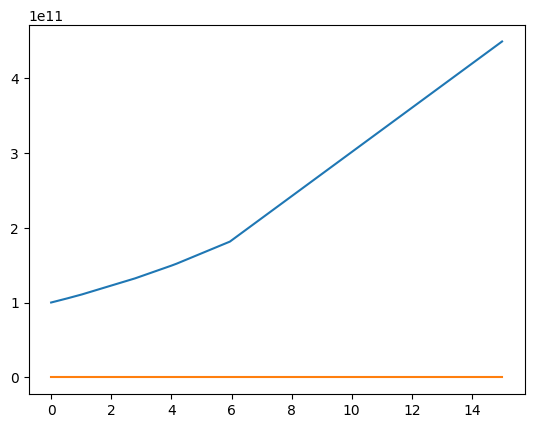

In [3]:
print(result.y_history)
import matplotlib.pyplot as plt

plt.plot(result.t_history, result.y_history.T)

# Rescue mutant

In [4]:
seed = None
if seed is not None:
    rng = np.random.default_rng(seed)
else:
    rng = np.random.default_rng()

y0 = np.array([
    10e8, # target cells
    10e1,  # wildtype infected cells
    0,     # mutant infected cells
])

# it's more natural to think about the columns — because they are reactions — and then transpose
N = np.array([
    [0,-1,0], # death of wildtype
    [0,0,-1], # death of mutant
    [-1,1,0], # infection --> new wildtypes (by wildtype)
    [-1,0,1], # infection --> mutation into mutant (by wildtype)
    [-1,0,1], # infection --> new mutants
]).T

rate_involvement_matrix = np.array([
    [0,1,0],
    [0,0,1],
    [1,1,0],
    [1,1,0],
    [1,0,1],
]).T

R0 = 0.8   # wildtype is dying out
d  = 10    # death rate for wild type per day
beta = R0 * d / (y0[0]) # beta derived from above two
mu = 0.001 # rare mutations can save it
dmu = 2 # mutant dies less
Rmu = beta * y0[0] / dmu
assert np.isclose(Rmu, R0 * d/dmu) # Rmu should be x times bigger where x is d/dmu

def rescue_probability(R0, Rmu, mu, y0):
    return 1 - np.exp((mu*R0*(1-1/Rmu)*y0[1])/(R0-1))

def k_of_t(t):
    return [d, dmu, beta, beta*mu, beta]

1 - rescue_probability(R0, Rmu, mu, y0)

0.7408182206817178

In [5]:
extinctions = 0
for i in range(1000):
    result = hybrid.forward_time(y0, [0, 15.0], lambda p: partition_by_threshold(p, 1000), k_of_t, N, rate_involvement_matrix, rng)
    extinctions += result.y[-1] == 0.0
    print("i", i, "Exctinctions:", extinctions, "extinction probability:", extinctions/i)
print("Expected extinction probability:", 1-rescue_probability(R0, Rmu, mu, y0))

IndexError: index 0 is out of bounds for axis 0 with size 0